# Fundamentals of Machine Learning - Exercise 6
Dominique Cheray & Manuel Krämer

In [3]:
import numpy as np
from scipy.sparse import linalg
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.ndimage.filters import gaussian_filter 

## 2 Denoising of a CT image

In [4]:
def construct_X(M, alphas, Np=None, tau=0):
    if not Np:
        Np = np.ceil(np.sqrt(2) * M).astype(int)
    if Np % 2 == 0:
        Np += 1
    D = M * M
    No = len(alphas)
    N = Np * No
    C1 = (np.mgrid[0:M, 0:M][0]).flatten()
    C2 = (np.mgrid[0:M, 0:M][1]).flatten()
    C = np.vstack((C1, C2))
    # centralise the coordinates in C
    C = C - (M - 1) / 2
    # convert alphas to radian
    alphas_rad = np.radians(alphas)
    # now make vectors out of the angles
    n = np.zeros((2, No))
    n[0] = -np.sin(alphas_rad)
    n[1] = np.cos(alphas_rad)
    p = n.T.dot(C) + (Np - 1) / 2
    lower_element = np.floor(p).astype(int)
    upper_element = np.ceil(p).astype(int)
    lower_value = upper_element - p
    upper_value = p - lower_element
    weights = []
    i_indices = []
    j_indices = []
    for i in range(No):
        for j in range(len(lower_element[i])):
            if (lower_element[i][j] == upper_element[i][j]):
                weights.append(1)
                i_indices.append(i*Np+lower_element[i][j])
                j_indices.append(j)
            else:
                weights.append(lower_value[i][j])
                i_indices.append((i*Np+lower_element[i][j]))
                j_indices.append(j)
                weights.append(upper_value[i][j])
                i_indices.append(((i*Np+upper_element[i][j])))
                j_indices.append(j)
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
    # if tau is given construct the diagonal matrix and append it to X
    if tau != 0:
        x_indices = np.arange(D)
        y_indices = np.arange(D)
        taus = np.full((D), np.sqrt(tau))
        tauMatrix = coo_matrix((taus, (x_indices, y_indices)), shape=(D, D), dtype=np.float32)
        X = scipy.sparse.vstack((X, tauMatrix))
    return X


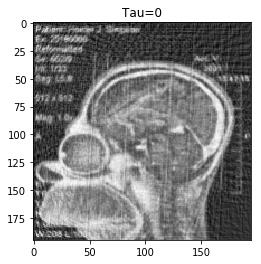

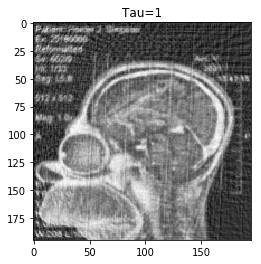

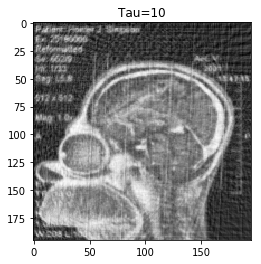

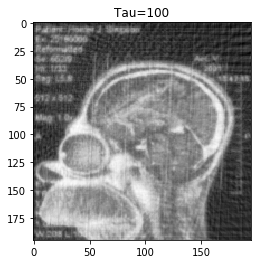

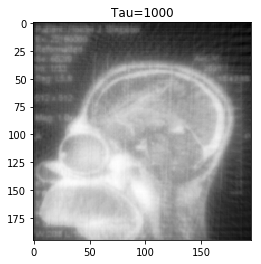

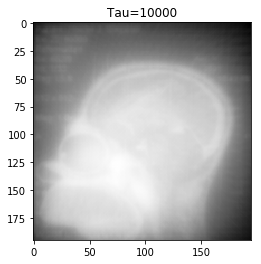

In [13]:
alphas = np.load('hs_tomography/alphas_195.npy')
y = np.load('hs_tomography/y_195.npy')
Np = 275
M = 195
newy = np.array([])
length = len(alphas)
stepsize = 3  # to get 64 angles take every 3rd angle from original
newalphas = []
for i in range(0, length, stepsize):
    newalphas.append(alphas[i])
    data = y[np.arange(i*Np, i*Np+Np)]
    newy = np.concatenate((newy, data))

# don't include tau=0 it will be handede separately because
# the image is needed later for the gaussian filtering
taus = [1, 10, 100, 1000, 10000]
# now start with tau = 0
X = construct_X(M, newalphas, Np, 0)
X_csc = X.tocsc()
img_tau_zero = linalg.lsqr(X_csc, newy, atol=1e-05, btol=1e-05)
img_tau_zero = img_tau_zero[0]
img_tau_zero = img_tau_zero.reshape((M, M))
plt.imshow(img_tau_zero, cmap=plt.cm.Greys_r)
plt.title('Tau=0')
plt.show()

# now construct a new y vector with zeros appendend 
# for the cases where tau is not zero
zeros = np.zeros(M*M)
newy = np.concatenate((newy, zeros))
for tau in taus:
    X = construct_X(M, newalphas, Np, tau)
    X_csc = X.tocsc()
    img = linalg.lsqr(X_csc, newy, atol=1e-05, btol=1e-05)
    img = img[0]
    img = img.reshape((M, M))
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.title('Tau=%i' %(tau))
    plt.show()

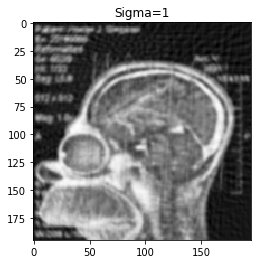

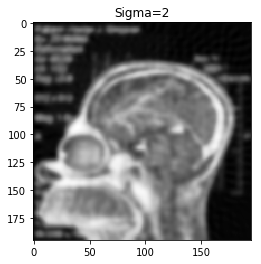

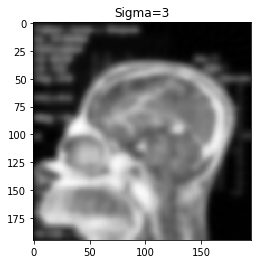

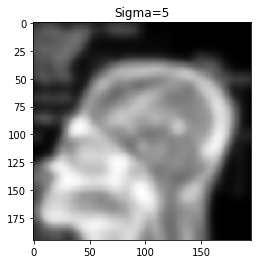

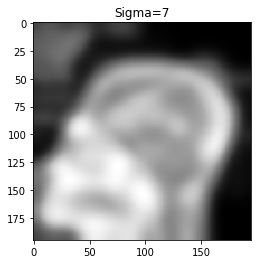

In [12]:
# now do the Gaussian filtering
sigmas = [1, 2, 3, 5, 7]
for sigma in sigmas:
    filtered_image = gaussian_filter(img_tau_zero, sigma)
    plt.imshow(filtered_image, cmap=plt.cm.Greys_r)
    plt.title('Sigma=%i' % sigma)
    plt.show()

For both methods increasing tau respectively sigma improves the result only until a certain level later on the images get worse. For Gaussian filtering the image already starts to get blurrier when sigma is increast to 2. Using the ridge regression the image gets worse when increasing tau to 1000. The Gaussian filtering reduces the noise more than the Ridge Regression, but also looses contrast. The Ridge Regression images stay relatively sharp but at some point the lighter parts of the image seam smeared all over the image. 